<a href="https://colab.research.google.com/github/u6yuvi/DL-POC/blob/main/NLP/Text_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup Gdrive + Kaggle CLI

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')
#* updating filepath to your Google Drive

# #Make sure you have this path available in your google drive
# filepath="/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"u6yuvi","key":"62a8a2d8ea2f0d4d01b1bd812b047418"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 60% 14.0M/23.4M [00:00<00:00, 25.1MB/s]
100% 23.4M/23.4M [00:00<00:00, 47.8MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 99.5MB/s]
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 94.3MB/s]
 34% 9.00M/26.3M [00:00<00:00, 30.6MB/s]
100% 26.3M/26.3M [00:00<00:00, 66.6MB/s]


In [6]:
!unzip -qq train.csv.zip
#!unzip -qq test.zip

#Install

In [7]:
!pip install -q transformers

     |████████████████████████████████| 1.4MB 8.8MB/s 
     |████████████████████████████████| 2.9MB 16.3MB/s 
     |████████████████████████████████| 890kB 61.6MB/s 


In [8]:
!pip install -U -q watermark

In [9]:
%reload_ext watermark
%watermark -v -p pandas,numpy,transformers

CPython 3.6.9
IPython 5.5.0

pandas 1.1.5
numpy 1.18.5
transformers 4.0.1


# Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch import nn , optim
from torch.utils.data import Dataset,DataLoader
%matplotlib inline

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [12]:
df = pd.read_csv("train.csv")
df.shape

(159571, 8)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [14]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


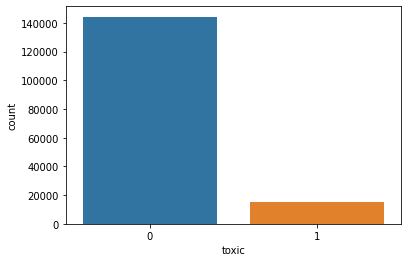

In [15]:
sns.countplot(df.toxic)

# Data Preprocessing


In [16]:
df.comment_text.tolist()[:5]

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
 '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on r

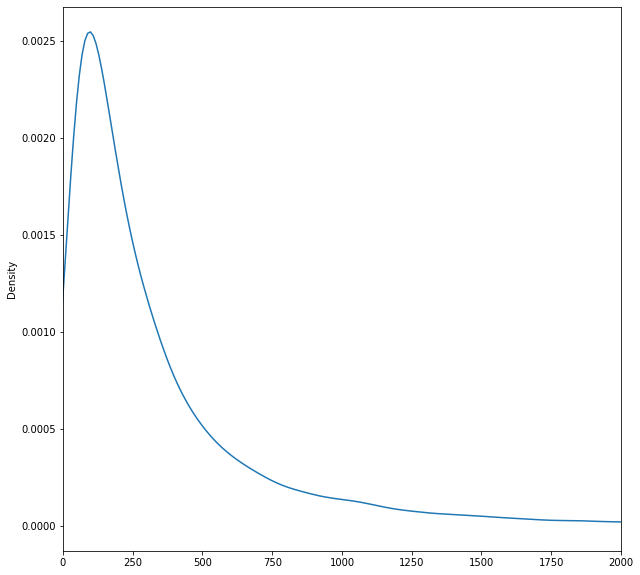

In [17]:
#Length of the comments_text
df.comment_text.apply(lambda x : len(x)).plot(kind = 'kde',xlim = (0,2000),figsize=(10,10))


# Tokenizer

In [18]:
from transformers import BertTokenizer

In [19]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [20]:
sentence = df.comment_text.iloc[0]
tokens = tokenizer.tokenize(sentence)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f'Sentence:{sentence}')
print(f'Tokens:{tokens}')
print(f'Token_ids:{token_ids}')

Sentence:Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Tokens:['Ex', '##p', '##lana', '##tion', 'Why', 'the', 'edit', '##s', 'made', 'under', 'my', 'user', '##name', 'Hard', '##core', 'Metal', '##lica', 'Fan', 'were', 'reverted', '?', 'They', 'weren', "'", 't', 'van', '##dal', '##isms', ',', 'just', 'closure', 'on', 'some', 'GA', '##s', 'after', 'I', 'voted', 'at', 'New', 'York', 'Doll', '##s', 'FA', '##C', '.', 'And', 'please', 'don', "'", 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'I', "'", 'm', 'retired', 'now', '.', '89', '.', '205', '.', '38', '.', '27']
Token_ids:[16409, 1643, 20592, 2116, 2009, 1103, 14609, 1116, 1189, 1223, 1139, 4795, 16124, 9322, 9475, 9953, 9538, 16061, 1127, 17464, 136, 1220, 3920, 112, 189, 3498, 6919, 16762, 1

In [21]:
assert len(tokens) == len(token_ids)

# Special Tokens

In [22]:
print(tokenizer.sep_token,tokenizer.sep_token_id)

[SEP] 102


In [23]:
print(tokenizer.cls_token,tokenizer.cls_token_id)


[CLS] 101


In [24]:
print(tokenizer.pad_token,tokenizer.pad_token_id)

[PAD] 0


In [25]:
print(tokenizer.unk_token,tokenizer.unk_token_id)

[UNK] 100


In [26]:
enc = tokenizer.encode_plus(df.comment_text.iloc[18],
                      max_length = 128,
                      truncation = True,
                      add_special_tokens = True,  ##[CLS] +[SEP]
                      return_token_type_ids = False,
                      return_attention_mask = True,
                      return_tensors = 'pt')

In [27]:

vars(enc)

{'_encodings': None,
 '_n_sequences': None,
 'data': {'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1]]),
  'input_ids': tensor([[  101,  1109, 12107,  9552, 27744,  1182,  1553,  1189,  1185,  2305,
             118,  1725,  1136,  6982,  1106,  1511,  9001,  1113,   155,  7490,
           17784,  1968, 21150,   112,   188,  3674,  1106,  1511,  1167,  1869,
             136,   102]])}}

In [28]:
print(len(enc["attention_mask"][0]),len(enc["input_ids"][0]))

32 32


In [29]:
tokenizer.convert_ids_to_tokens(enc['input_ids'][0])

['[CLS]',
 'The',
 'Mi',
 '##tsu',
 '##rug',
 '##i',
 'point',
 'made',
 'no',
 'sense',
 '-',
 'why',
 'not',
 'argue',
 'to',
 'include',
 'Hindi',
 'on',
 'R',
 '##yo',
 'Sa',
 '##ka',
 '##zaki',
 "'",
 's',
 'page',
 'to',
 'include',
 'more',
 'information',
 '?',
 '[SEP]']

# Create Custom Pytorch DataLoader


In [30]:
class ToxicDataset(Dataset):
  def __init__(self,comment,target,tokenizer,max_len):
    self.comment = comment
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comment)

  def __getitem__(self,item):
    comment = str(self.comment[item])
    target  = self.target[item]

    encoding = self.tokenizer.encode_plus(comment,
                      max_length = 128,
                      truncation = True,
                      add_special_tokens = True,  ##[CLS] +[SEP]
                      return_token_type_ids = False,
                      return_attention_mask = True,
                      pad_to_max_length = True,
                      return_tensors = 'pt')
    #print(len(encoding["attention_mask"][0]),len(encoding["input_ids"][0]))
    return {
        "comment_text":comment,
        "input_ids":encoding["input_ids"].flatten(),
        "attention_mask":encoding["attention_mask"].flatten(),
        "targets":torch.tensor(target,dtype = torch.long)
    }

In [31]:
df_train,df_test  = train_test_split(df,test_size = 0.2,random_state=123)
df_val,df_test  = train_test_split(df_test,test_size = 0.5,random_state=123)

In [32]:

df_train.shape,df_val.shape,df_test.shape

((127656, 8), (15957, 8), (15958, 8))

# Create DataLoader



In [33]:
def comment_data_loader(df,tokenizer,max_len,batch_size):
  toxic_dataset = ToxicDataset(comment = df.comment_text.to_numpy(),
                               target = df.toxic.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = max_len)
  
  return DataLoader(toxic_dataset,batch_size=batch_size,num_workers=4)

In [34]:
MAX_LEN = 128
BATCH_SIZE = 2
train_data_loader = comment_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = comment_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)

In [35]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'targets'])

In [36]:
print(data["comment_text"])
print(data["input_ids"])

["I know my comment was wrong, but what I'm trying to say is that he is stalking my edits! Even if I make a comment on the natural wildlife in north Punjab province, he's theres.", '"\nErgo, it\'s neither the flag of the PA nor of the ""Palestinian Territories"" (whatever that means), but of a now-defunct British protectorate, and therefor belongs un nneither infobox. What\'s your point again? And where are your reliable sources backing it up? 24.177.122.31  "']
tensor([[  101,   146,  1221,  1139,  7368,  1108,  2488,   117,  1133,  1184,
           146,   112,   182,  1774,  1106,  1474,  1110,  1115,  1119,  1110,
         23281,  1139, 14609,  1116,   106,  2431,  1191,   146,  1294,   170,
          7368,  1113,  1103,  2379, 10501,  1107,  1564,  8907,  3199,   117,
          1119,   112,   188,  1175,  1116,   119,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,  

In [37]:
print(data["input_ids"].shape)
print(data["attention_mask"].shape)
print(data["targets"].shape)

torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2])


In [38]:
data["input_ids"]

tensor([[  101,   146,  1221,  1139,  7368,  1108,  2488,   117,  1133,  1184,
           146,   112,   182,  1774,  1106,  1474,  1110,  1115,  1119,  1110,
         23281,  1139, 14609,  1116,   106,  2431,  1191,   146,  1294,   170,
          7368,  1113,  1103,  2379, 10501,  1107,  1564,  8907,  3199,   117,
          1119,   112,   188,  1175,  1116,   119,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

# Bert Model

In [39]:
from transformers import BertModel

In [40]:
PRETRAINED_MODEL_NAME = "bert-base-cased"
bert_model = BertModel.from_pretrained(PRETRAINED_MODEL_NAME)

In [41]:
enc

{'input_ids': tensor([[  101,  1109, 12107,  9552, 27744,  1182,  1553,  1189,  1185,  2305,
           118,  1725,  1136,  6982,  1106,  1511,  9001,  1113,   155,  7490,
         17784,  1968, 21150,   112,   188,  3674,  1106,  1511,  1167,  1869,
           136,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}

In [42]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [43]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

In [44]:
output = bert_model(**enc)

In [45]:
output

BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[ 0.6845, -0.0810,  0.0153,  ..., -0.2105, -0.0649, -0.2277],
                                                        [ 0.0815, -0.4615,  0.4054,  ...,  0.5217, -0.1802,  0.1272],
                                                        [ 0.1511, -0.0035,  0.7891,  ...,  0.2683, -0.5806, -0.3902],
                                                        ...,
                                                        [ 0.6177,  0.0620,  0.2881,  ...,  0.2093, -0.1116,  0.0328],
                                                        [ 0.4378, -0.4630,  0.1347,  ...,  0.1306, -0.4123,  0.2538],
                                                        [ 1.3969, -0.1733,  0.4659,  ..., -0.4534,  0.0131, -1.2319]]],
                                                      grad_fn=<NativeLayerNormBackward>)),
                                              ('pooler_output',
      

In [46]:
print(output["last_hidden_state"].shape)
print(output["pooler_output"].shape)

torch.Size([1, 32, 768])
torch.Size([1, 768])


In [47]:
last_hidden_state,pooled_output = bert_model(**enc)


# Building Task specific Head over BERT 

In [48]:
class ToxicModel(nn.Module):
  def __init__(self,n_classes):
    super(ToxicModel,self).__init__()
    self.bert  =BertModel.from_pretrained(PRETRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.2)
    self.output = nn.Linear(self.bert.config.hidden_size,n_classes)

  
  def forward(self,input_ids,attention_masks):
    bert_output = self.bert(input_ids,attention_masks)
    out  = self.drop(bert_output.pooler_output)
    return self.output(out)

In [49]:
N_CLASSES = df_train.toxic.nunique()
model = ToxicModel(N_CLASSES)

In [50]:
model

ToxicModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [51]:
import torch.nn.functional as F
F.softmax(model(enc["input_ids"],enc["attention_mask"]),dim=1)

tensor([[0.4547, 0.5453]], grad_fn=<SoftmaxBackward>)

In [52]:
model(enc["input_ids"],enc["attention_mask"])

tensor([[-0.2608,  0.2428]], grad_fn=<AddmmBackward>)

In [53]:
from transformers import AdamW, get_linear_schedule_with_warmup
EPOCHS = 2
optimizer = AdamW(model.parameters(),lr = 2e-5, correct_bias = False)
total_steps = len(train_data_loader)*EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)


In [54]:
def train_model(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model.train().to(device)
  losses = []
  correct_predictions = 0

  for data in data_loader:
    input_ids = data["input_ids"].to(device)
    attention_mask = data["attention_mask"].to(device)
    targets = data["targets"].to(device)

    outputs = model(input_ids,attention_mask)
    _,preds = torch.max(outputs,dim=1)
    loss = loss_fn(outputs,targets)
    correct_predictions+= torch.sum(preds ==targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm(model.parameters(),max_norm = 1)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses) 

In [55]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids,attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [56]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_model(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.3295240240035447 accuracy 0.9342138246537569


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.2664181273229824 accuracy 0.9525600050134736

Epoch 2/2
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.36754996516024796 accuracy 0.9349815128156921


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4557389836501704 accuracy 0.9153349627122892



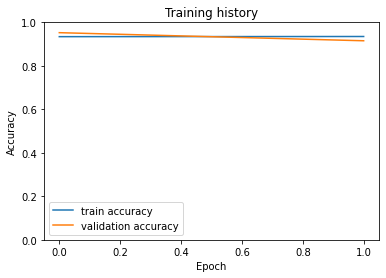

In [57]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [58]:

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

NameError: ignored

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)